# Laboratorio 1: Regresión en Boston

En este laboratorio deben hacer experimentos de regresión con el conjunto de datos "Boston house prices dataset".

Estudiarán el dataset, harán visualizaciones y seleccionarán atributos relevantes a mano.

Luego, entrenarán y evaluarán diferentes tipos de regresiones, buscando las configuraciones que mejores resultados den.

## Importaciones

In [1]:
! pip install rich
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

from rich.console import Console
from rich.table import Table

%matplotlib inline
# %matplotlib notebook

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip freeze > requirements.txt

## Carga del Conjunto de Datos

Cargamos el conjunto de datos y vemos su contenido.

In [3]:
boston = load_boston()
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

## Ejercicio 1: Descripción de los Datos y la Tarea

Responda las siguientes preguntas:

1. ¿De qué se trata el conjunto de datos?
2. ¿Cuál es la variable objetivo que hay que predecir? ¿Qué significado tiene?
3. ¿Qué información (atributos) hay disponibles para hacer la predicción?
4. ¿Qué atributos imagina ud. que serán los más determinantes para la predicción?
5. ¿Qué problemas observa a priori en el conjunto de datos? ¿Observa posibles sesgos, riesgos, dilemas éticos, etc? Piense que los datos pueden ser utilizados para hacer predicciones futuras.

**No hace falta escribir código para responder estas preguntas.**

**1.** El conjunto de datos, tal como consta en la [descripción de los mismos](#Carga-del-Conjunto-de-Datos), se trata de valor de propiedades en Boston en base a 13 variables. Estos datos están tomados de un paper de Harrison, D. and Rubinfeld, D.L.: [Hedonic prices and the demand for clean air](https://www.researchgate.net/publication/4974606_Hedonic_housing_prices_and_the_demand_for_clean_air).

**2.** La variable objetivo es **MEDV (MEDian Value)**, es decir, el  valor de la mediana tomando los registros del grupo de viviendas que comparten características similares con ella.

Lo que se debe tener en cuenta es que el dataset es del año 1978, por lo que si no se tienen en cuenta los incrementos por inflación, cualquier algoritmo de regresión que se haga con base en estos datos, la prediciión de valor de las viviendas serán para el año de publicación de paper, valor desactualizado para la presente época.

**3.** Se dispone de 13 variables según se explica en la [descripción del dataset](#Carga-del-Conjunto-de-Datos).

- CRIM: Tasa de criminalidad.
- ZN: Proporción de suelo residencial zonificado para lotes de más de 25,000 pies cuadrados.
- INDUS: Proporción de acres comerciales no minoristas por ciudad.
- CHAS: Variable ficticia de Charles River ($1$ si la casa limita con el río; $0$ en caso contrario).
- NOX: Concentración de óxidos nítricos (partes por 10 millones), es un indicio del nivel de contaminación.
- RM: Promedio de habitaciones.
- AGE: Proporción de unidades ocupadas por sus propietarios construidas antes de 1940.
- DIS: Distancias ponderadas a 5 zonas de trabajo en Boston.
- RAD: Índice de accesibilidad a autopistas.
- TAX: Tasa de impuesto a la propiedad de valor total por 10,000 dólares.
- PTRATIO: Relación entre cantidad de alumnos y maestros.
- B: Atributo que da un indicio de la población de personas de color (específicamente negros). B = 0 (63% de población negra). B aumenta en la medida en que disminuye la población negra.
- LSTAT: Porcentaje de población de bajo estatus.

**4.** A priori, intuimos que los atributos más determinantes para la predicción de MEDV es la cantidad de habitaciones (RM) que tiene la propiedad, tasa de criminalidad (CRIM) y distancias ponderadas a 5 zonas de trabajo en Boston (DIS).

**5.** Este dataset presenta problemas éticos; de hecho, consta en la misma documentación de scikit.learn, a la que se puede acceder haciendo [click aquí](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html#sklearn-datasets-load-boston). El dataset es obsoleto en la versión 1.0 y ya no estará disponible en la versión 1.2.

Seguramente la razón de esto son los sesgos raciales implícitos en las variables LSTAT (porcentaje de población de bajo estatus social) y B (que depende de la proporción de gente negra).

Estos datos presentan sesgos que ponen en evidencia ciertos paradigmas sociales que, con justa razón, se pueden entender como discriminatorios. Por ende, pretender hacer predicciones con este dataset podría ofender a algunas personas o exponernos a acusaciones por discriminación y racismo.

## Ejercicio 2: Visualización de los Datos

1. Para cada atributo de entrada, haga una gráfica que muestre su relación con la variable objetivo.
2. Estudie las gráficas, identificando **a ojo** los atributos que a su criterio sean los más informativos para la predicción.
3. Para ud., ¿cuáles son esos atributos? Lístelos en orden de importancia.

A modo de preparación de los datos, creamos un DataFrame de Pandas con la información del dataset para usarlo en el ejercicio y el resto del Notebook.

In [4]:
data = pd.DataFrame(data=boston.data, columns=boston.feature_names)
data['MEDV'] = boston.target
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


**1.a** En la próxima celda se encuentra una gráfica del valor de la mediana en miles de dólares (MEDV) en función de cada uno de los atributos. 13 gráficos en total.

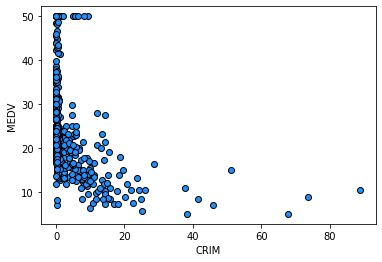

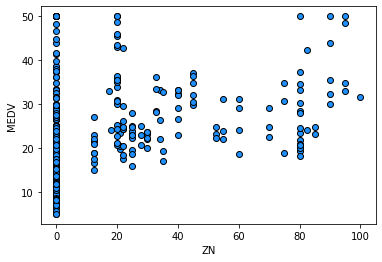

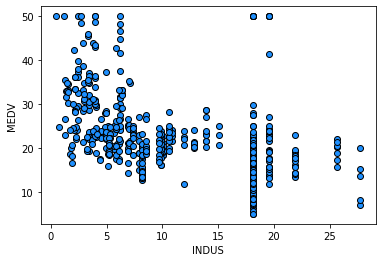

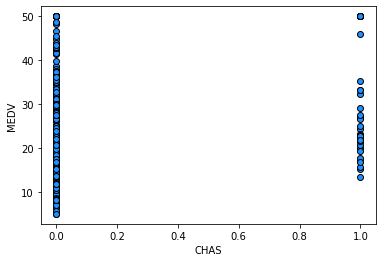

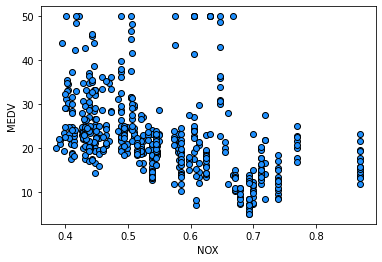

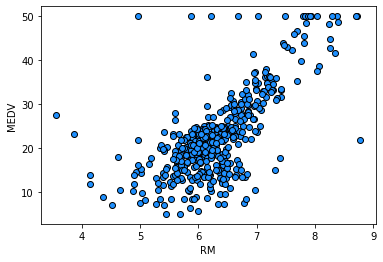

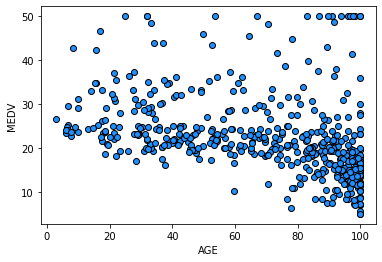

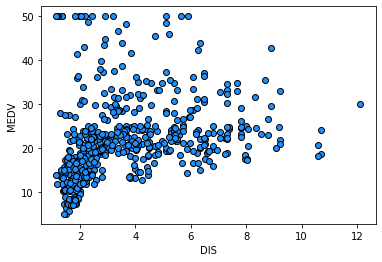

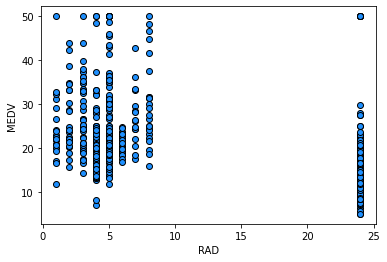

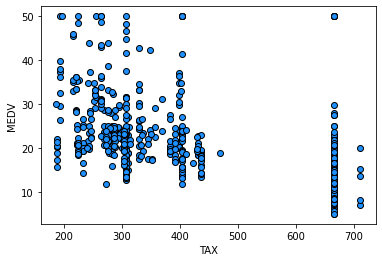

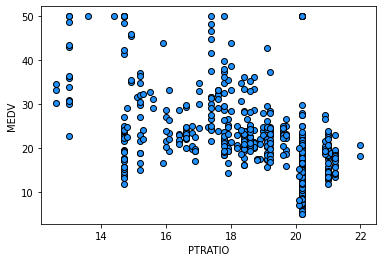

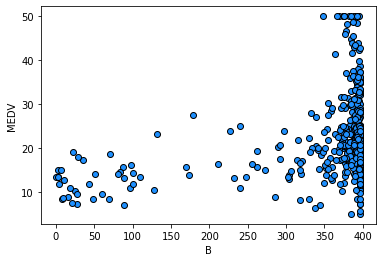

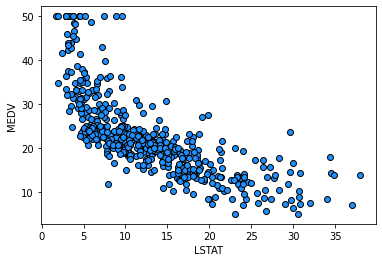

In [5]:
for feature in boston['feature_names']:
    plt.figure()
    plt.scatter(data[feature], data.MEDV, facecolor="dodgerblue", edgecolor="k", label="datos")
    plt.xlabel(feature)
    plt.ylabel('MEDV')
    plt.show()

**1.b** En la próxima celda graficamos un mapa de calor para los todos los atributos prestando especial atencion a la correlacion con el atributo objetivo MEDV

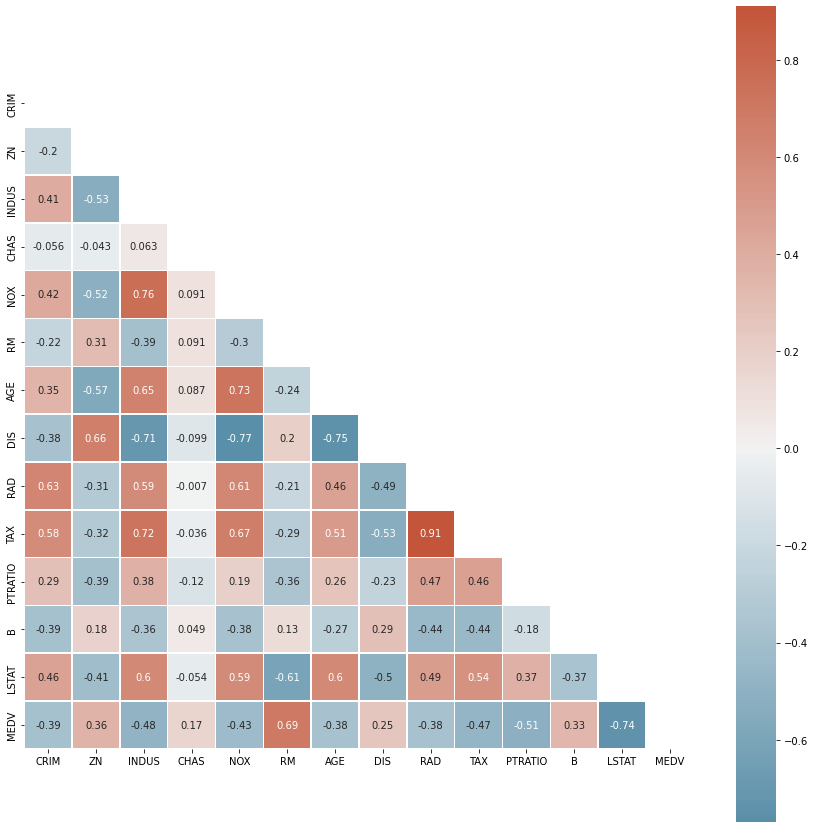

In [6]:
mask = np.triu(np.ones_like(data.corr(), dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = seaborn.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
seaborn.heatmap(round(data.corr(),3), mask=mask, cmap=cmap,annot=True, center=0,
            square=True, linewidths=.5)


In [7]:
data.corr()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CRIM,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621,-0.388305
ZN,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995,0.360445
INDUS,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800,-0.483725
CHAS,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929,0.175260
NOX,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879,-0.427321
RM,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808,0.695360
AGE,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339,-0.376955
DIS,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996,0.249929
RAD,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676,-0.381626
TAX,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993,-0.468536


**2. y 3.** Después de analizar las gráficas, se puede apreciar que los atributos que más influyen sobre la mediana del valor de la propiedad, ergo los más informativos para la predicción, en orden de mayor a menor son:
- LSTAT (alta correlacion negativa): El valor de las propiedades disminuye notablemente en la medida en que se encuentra en zonas pobladas por personas de bajo estatus social.
- RM (alta correlacion positiva): El valor de la propiedad aumenta notablemente en función de la cantidad de habitaciones que posee.

- PTRATIO (correlacion negativa): La relacion alumnos-docentes disponibles en la zona tiene alguna influencia en el valor de la propiedad, es decir, el mismo aumenta si hay mas docentes disponibles en la zona que alumnos lo que indicaria vacantes disponibles en escuelas en la zona.

Los demas atributos muestran una correlacion inferior a 0.5 que es nuestro corte para este analisis, a partir del cual creemos que la correlacion lineal es baja como para considerarla influyente en la prediccion de MEDV (de hecho PTRATIO ya muestra bastante dispersion en los datos)


## Ejercicio 3: Regresión Lineal

1. Seleccione **un solo atributo** que considere puede ser el más apropiado.
2. Instancie una regresión lineal de **scikit-learn**, y entrénela usando sólo el atributo seleccionado.
3. Evalúe, calculando error cuadrático medio para los conjuntos de entrenamiento y evaluación.
4. Grafique el modelo resultante, junto con los puntos de entrenamiento y evaluación.
5. Interprete el resultado, haciendo algún comentario sobre las cualidades del modelo obtenido.

**Observación:** Con algunos atributos se puede obtener un error en test menor a 50.

**1.** Seleccionamos el atributo RM, en virtud de que, entendemos, tiene mayor influencia sobre el valor de la propiedad.

In [8]:
atributo = 'LSTAT'
X = data[[atributo]]
y = data.MEDV

**2.** Instanciación y entrenamiento del atributo seleccionado.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

**3.** Evaluación mediante cálculo del error medio cuatrático.

In [10]:
def mse_on_set(X, y):
  return mean_squared_error(y, regr.predict(X))

regr = LinearRegression()
regr.fit(X_train, y_train)

print(f'El error cuadrático medio para el conjunto de entrenamiento es: {round(mse_on_set(X_train, y_train), 3)}.')
print(f'El error cuadrático medio para el conjunto de evaluación es: {round(mse_on_set(X_test, y_test), 3)}.')

El error medio cuadrático para el conjunto de entrenamiento es: 36.524.
El error medio cuadrático para el conjunto de evaluación es: 46.336.


**4.** Gráfica del modelo resultante

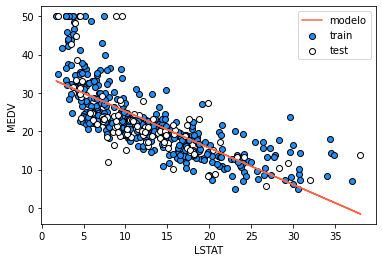

In [11]:
plt.figure()
plt.scatter(X_train, y_train, facecolor="dodgerblue", edgecolor="k", label="train")
plt.scatter(X_test, y_test, facecolor="white", edgecolor="k", label="test")
plt.plot(X, regr.predict(X), color="tomato", label="modelo")
plt.xlabel(feature)
plt.ylabel('MEDV')
plt.legend()
plt.show()

**5.** Si bien la distribución de datos no es lineal, el modelo aparenta tener un buen comportamiento entre 10 y 30. Representa la realidad que expresan los datos, que MEDV es inversamente proporcional al porcentaje de población de bajo estatus.

## Ejercicio 4: Regresión Polinomial

En este ejercicio deben entrenar regresiones polinomiales de diferente complejidad, siempre usando **scikit-learn**.

Deben usar **el mismo atributo** seleccionado para el ejercicio anterior.

1. Para varios grados de polinomio, haga lo siguiente:
    1. Instancie y entrene una regresión polinomial.
    2. Prediga y calcule error en entrenamiento y evaluación. Imprima los valores.
    3. Guarde los errores en una lista.
2. Grafique las curvas de error en términos del grado del polinomio.
3. Interprete la curva, identificando el punto en que comienza a haber sobreajuste, si lo hay.
4. Seleccione el modelo que mejor funcione, y grafique el modelo conjuntamente con los puntos.
5. Interprete el resultado, haciendo algún comentario sobre las cualidades del modelo obtenido.

**Observación:** Con algunos atributos se pueden obtener errores en test menores a 40 e incluso a 35.

In [12]:
# 1.

def instantiate_pol_regr (degree, X, y):
    '''Instancia y entrena una regresión polinomial de grado deegree.
    
    Parámetros:
    -----------
    deegre: Grado del polinomio
    X: Conjunto de atributos
    y: Conjunto de datos objetivo
    
    Salida:
    -------
    model: Objeto con el modelo de la regresión polinimial
    '''
    pf = PolynomialFeatures(degree)
    lr = LinearRegression(fit_intercept=False)  # el bias ya esta como feature
    model = make_pipeline(pf, lr)
    model.fit(X, y)
    return model

reg_errores = []
max_degree = 10

deegrees = range(2, max_degree+1)

titulo = "Errores del modelo."
columnas = ["Grado del polinomio",
            "Error de entrenamiento",
            "Error de evaluación"]

table = Table(title=titulo)

for columna in columnas:
    table.add_column(columna, justify="center", style="blue")
            
for degree in deegrees:
    model = instantiate_pol_regr(degree, X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_test)
    train_error = mean_squared_error(y_train, y_train_pred)
    val_error = mean_squared_error(y_test, y_val_pred)
    reg_errores.append([degree, round(train_error, 2), round(val_error, 2)])
    table.add_row(str(degree),
                  str(round(train_error, 2)),
                  str(round(val_error, 2)))
    
console = Console()
console.print(table)

                         Errores del modelo.                          
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Grado del polinomio ┃ Error de entrenamiento ┃ Error de evaluación ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│          2          │         28.19          │        38.85        │
│          3          │         26.78          │        37.22        │
│          4          │         25.85          │        34.7         │
│          5          │         25.03          │        34.83        │
│          6          │         25.01          │        34.33        │
│          7          │         25.01          │        34.26        │
│          8          │         24.85          │        36.42        │
│          9          │         24.83          │        34.92        │
│         10          │         30.35          │        61.43        │
└─────────────────────┴────────────────────────┴─────────────────────┘

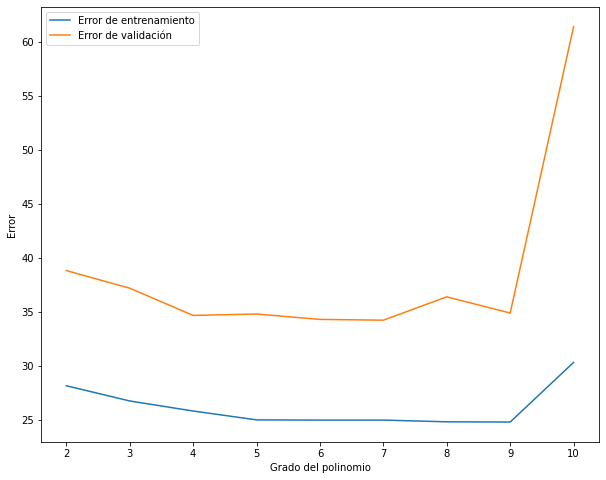

In [13]:
# 2.

degree = [x[0] for x in reg_errores]
train_error = [x[1] for x in reg_errores]
test_error = [x[2] for x in reg_errores]

plt.figure(figsize=(10, 8))
plt.plot(degree, train_error, label='Error de entrenamiento')
plt.plot(degree, test_error, label='Error de validación')
plt.xlabel('Grado del polinomio')
plt.ylabel('Error')
plt.legend()
plt.show()

**3.** El sobreajuste comienza a partir del grado 7. A partir de ese grado aumenta el error de validación. A partir del grado 9 aumenta el error de entrenamiento y el de validación se incrementa bruscamente.

**4.** Gráfico del modelo junto con los datos.

Se grafica el modelo polinomial de grado 4 por tratarse del polinomio de menor grado con un menor ECM en el conjunto de validacion. Modelos polinomiales de grados 6 y 7 tienen compotamiento similar pero con mayor costo computacional.

In [14]:
OPTIMAL_DEGREES = 4

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  "X does not have valid feature names, but"


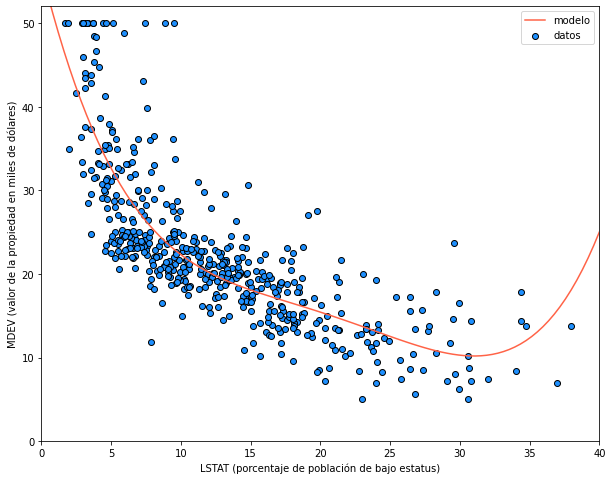

In [15]:
model = instantiate_pol_regr(OPTIMAL_DEGREES, X_train, y_train)

X = np.linspace(0, 40, 100)
y = model.predict(X.reshape(-1, 1))

plt.figure(figsize=(10, 8))
plt.scatter(data.LSTAT, data.MEDV, facecolor="dodgerblue", edgecolor="k", label="datos")
plt.plot(X, y, color="tomato", label="modelo")
plt.xlim([0, 40])
plt.ylim([0, 52])
plt.xlabel('LSTAT (porcentaje de población de bajo estatus)')
plt.ylabel('MDEV (valor de la propiedad en miles de dólares)')
plt.legend()
plt.show()

**5.** El modelo presenta una importante mejoría respecto del modelo lineal en cuanto a que sigue el comportamiento de los datos aunque la dispersión de los mismos respecto de la curva que define el modelo explica el error medio cuadrático.

## Ejercicio 5: Regresión con más de un Atributo

En este ejercicio deben entrenar regresiones que toman más de un atributo de entrada.

1. Seleccione **dos o tres atributos** entre los más relevantes encontrados en el ejercicio 2.
2. Repita el ejercicio anterior, pero usando los atributos seleccionados. No hace falta graficar el modelo final.
3. Interprete el resultado y compare con los ejercicios anteriores. ¿Se obtuvieron mejores modelos? ¿Porqué?

**1. y 2.** Selección de atributos relevantes, cálculo de error de entrenamiento y evaluación, y gráfica de ambos errores.

                         Errores del modelo.                          
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Grado del polinomio ┃ Error de entrenamiento ┃ Error de evaluación ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│          2          │         18.66          │        28.14        │
│          3          │         17.08          │        28.57        │
│          4          │         14.19          │        34.0         │
│          5          │         12.91          │        34.2         │
│          6          │         12.35          │        34.92        │
│          7          │         12.21          │        70.26        │
└─────────────────────┴────────────────────────┴─────────────────────┘

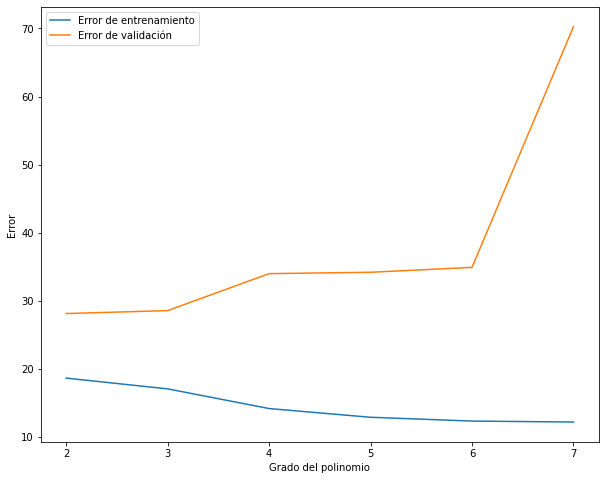

In [16]:
atributos_relevantes = ['RM', 'LSTAT']
X_2 = data[atributos_relevantes]
y = data.MEDV

X_train, X_test, y_train, y_test = train_test_split(X_2, y, train_size=0.8, random_state=0)

reg_errores = []
max_degree = 7

deegrees = range(2, max_degree+1)

titulo = "Errores del modelo."
columnas = ["Grado del polinomio",
            "Error de entrenamiento",
            "Error de evaluación"]

table = Table(title=titulo)

for columna in columnas:
    table.add_column(columna, justify="center", style="blue")
            
for degree in deegrees:
    model = instantiate_pol_regr(degree, X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_test)
    train_error = mean_squared_error(y_train, y_train_pred)
    val_error = mean_squared_error(y_test, y_val_pred)
    reg_errores.append([degree, round(train_error, 2), round(val_error, 2)])
    table.add_row(str(degree),
                  str(round(train_error, 2)),
                  str(round(val_error, 2)))
    
console = Console()
console.print(table)

degree = [x[0] for x in reg_errores]
train_error = [x[1] for x in reg_errores]
test_error = [x[2] for x in reg_errores]

plt.figure(figsize=(10, 8))
plt.plot(degree, train_error, label='Error de entrenamiento')
plt.plot(degree, test_error, label='Error de validación')
plt.xlabel('Grado del polinomio')
plt.ylabel('Error')
plt.legend()
plt.show()

**3.** Con regresión polinomial se pueden obtener bajos errores de entrenamiento, pero el error de validación crece apruptamente con el grado del polinomio. Esto habla de un fuerte sobreajuste para caso de utilizar regresión polinomial con dos o más atributos.

Con dos atributos (RM y LSTAT) se obtienen mejores resultados que con solamente LSTAT, para regresiones polinomiales de hasta grado 6. Esto se debe a que dos variables aportan más información que sólo una, es decir, el peso sobre cada uno de los atributos (representado por los coeficientes $\beta$  asociados a las variables RM y LSTAT) se debe ajustar a la información brindada por ambas.

## Más ejercicios (opcionales)

### Ejercicio 6: A Todo Feature

Entrene y evalúe regresiones pero utilizando todos los atributos de entrada (va a andar mucho más lento). Estudie los resultados.

### Ejercicio 7: Regularización

Entrene y evalúe regresiones con regularización "ridge". Deberá probar distintos valores de "alpha" (fuerza de la regularización). ¿Mejoran los resultados?